<a href="https://colab.research.google.com/github/Arthur-Barreto/Machine-Vision/blob/main/VisComp_Class_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class 6: Feature Detection and Convolutional Layers

## Preliminaries

Run the cell below to download the class pack.

In [1]:
import gdown

gdown.download(id='1TmXCDJ1annHEvOLBm8flwgohEOmZmr63')

!unzip -o '06.zip'
!rm '06.zip'

Downloading...
From: https://drive.google.com/uc?id=1TmXCDJ1annHEvOLBm8flwgohEOmZmr63
To: /content/06.zip
100%|██████████| 39.4M/39.4M [00:00<00:00, 52.8MB/s]


Archive:  06.zip
  inflating: bark-1.png              
  inflating: bark-2.png              
  inflating: bark-3.png              
  inflating: bark-4.png              
  inflating: bark-5.png              
  inflating: bark-6.png              
  inflating: bikes-1.png             
  inflating: bikes-2.png             
  inflating: bikes-3.png             
  inflating: bikes-4.png             
  inflating: bikes-5.png             
  inflating: bikes-6.png             
  inflating: boat-1.png              
  inflating: boat-2.png              
  inflating: boat-3.png              
  inflating: boat-4.png              
  inflating: boat-5.png              
  inflating: boat-6.png              
  inflating: graf-1.png              
  inflating: graf-2.png              
  inflating: graf-3.png              
  inflating: graf-4.png              
  inflating: graf-5.png              
  inflating: graf-6.png              
  inflating: leuven-1.png            
  inflating: leuven-2.png        

Run the cell below to import the class modules.

If you get import warnings, try using **Ctrl+m .** (notice there is a dot there) to restart the kernel.

In [2]:
import cv2 as cv

from sdx import *
from tensorflow import keras

## Part 1: Feature Detection

For this part, we will use the [Oxford affine covariant features dataset](https://www.robots.ox.ac.uk/~vgg/research/affine/).

By changing the two parameters below, you have 8x6=48 images to choose.

Possible values of `NAME`: `bikes`, `trees`, `graf`, `wall`, `bark`, `boat`, `leuven`, `ubc`

In [44]:
NAME = 'wall'

Possible values of `A` and `B`: `1`, `2`, `3`, `4`, `5`, `6`

In [45]:
A = 1
B = 3

The cell below loads the chosen images and converts them to gray.

Play a bit with the two parameters to see the differences between the images.

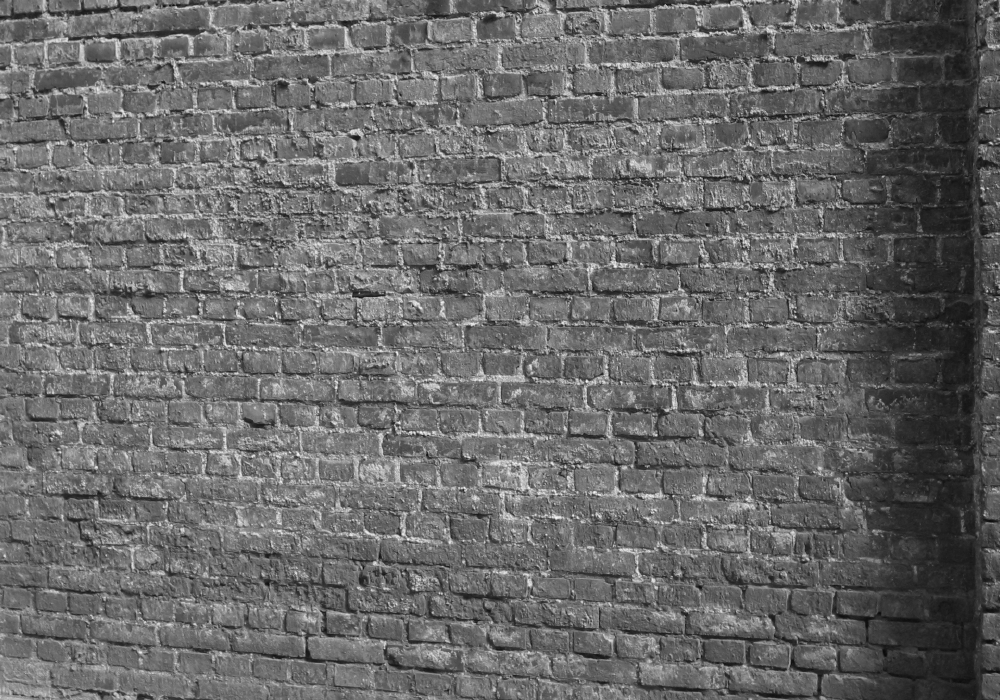

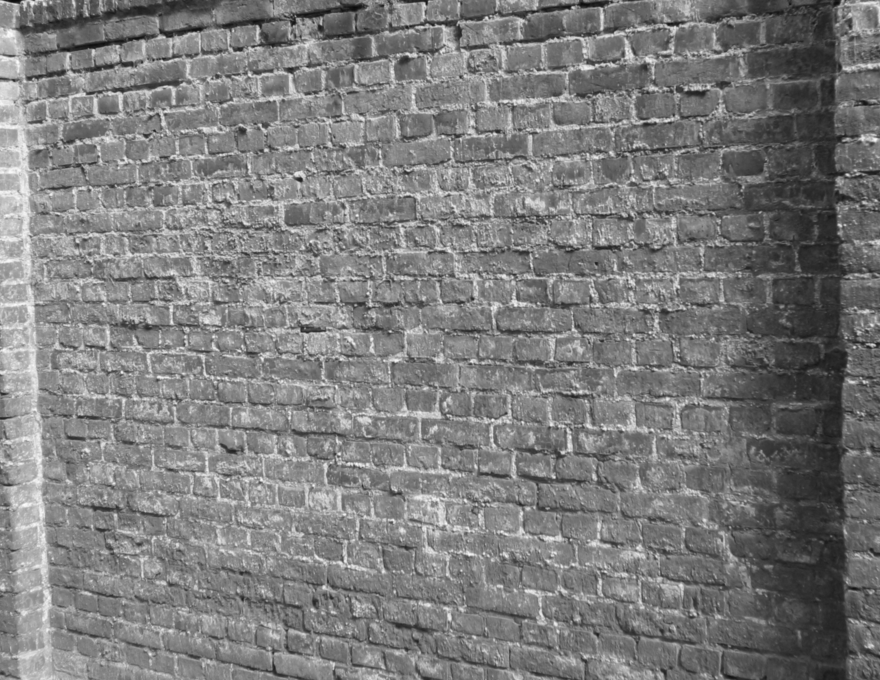

In [46]:
image_a = cv_grayread(f'{NAME}-{A}.png')
image_b = cv_grayread(f'{NAME}-{B}.png')

cv_imshow(image_a)
cv_imshow(image_b)

### Detecting keypoints and calculating descriptors

In [47]:
sift = cv.SIFT_create()

keypoints_a, descriptors_a = sift.detectAndCompute(image_a, None)
keypoints_b, descriptors_b = sift.detectAndCompute(image_b, None)

### Drawing descriptors with rotation and scale

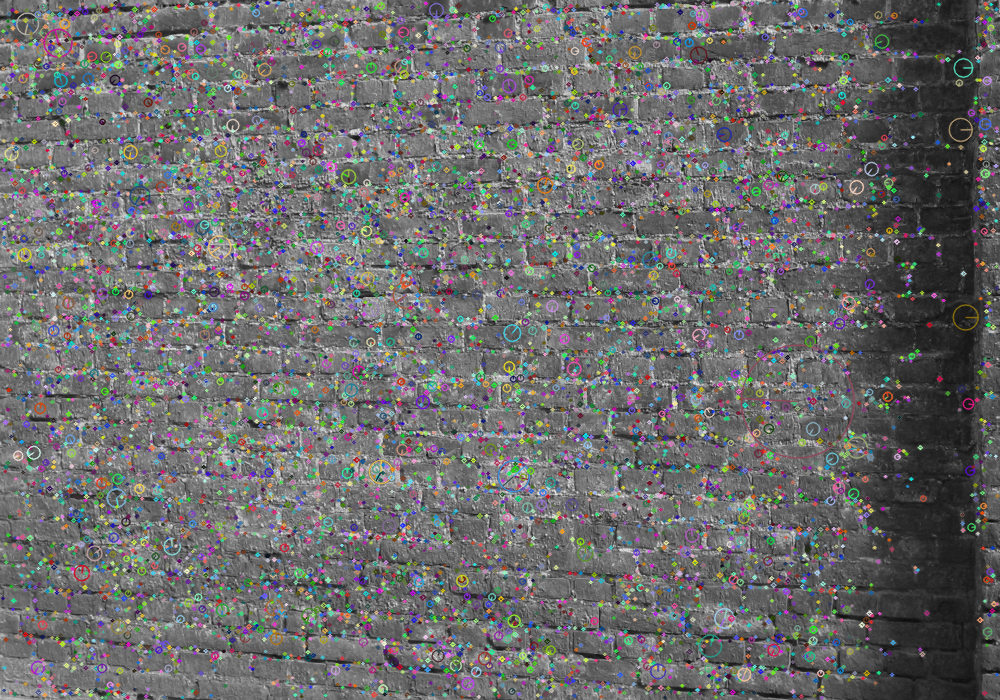

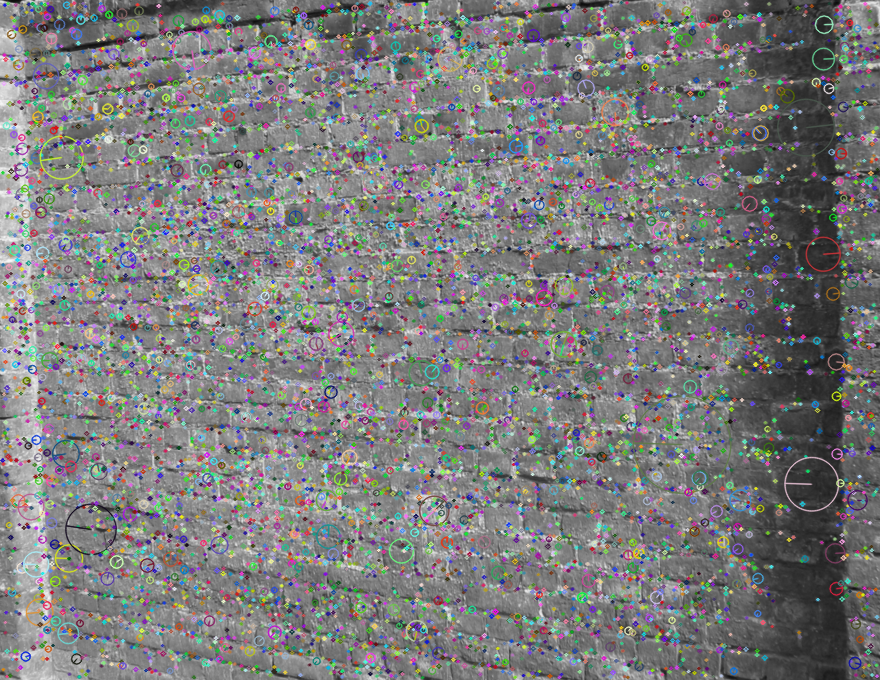

In [48]:
output_image_a = cv.drawKeypoints(image_a, keypoints_a, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
output_image_b = cv.drawKeypoints(image_b, keypoints_b, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv_imshow(output_image_a)
cv_imshow(output_image_b)

### Calculating the nearest neighbor pairs

In [49]:
LINEAR = 0
KDTREE = 1
KMEANS = 2
COMPOSITE = 3
KDTREE_SINGLE = 4
HIERARCHICAL = 5
LSH = 6

flann = cv.FlannBasedMatcher({'algorithm': KDTREE})

matches = flann.knnMatch(descriptors_a, descriptors_b, k=2)

### Drawing the best keypoint matches

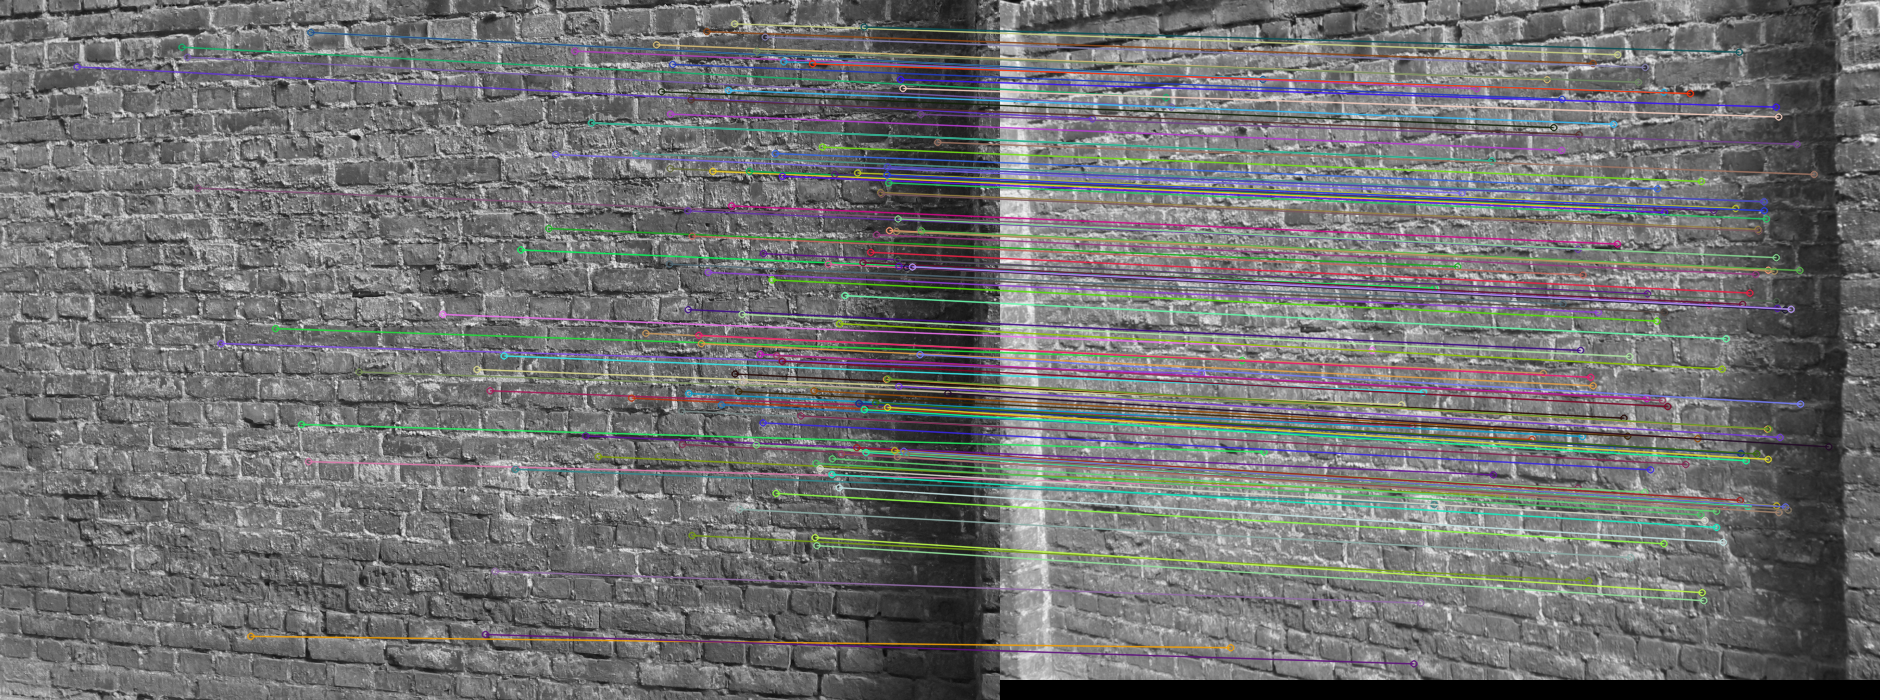

In [51]:
mask = [(0, 0)] * len(matches)

for i, (first, second) in enumerate(matches):
  if first.distance < 0.3 * second.distance:
    mask[i] = (1, 0)

kwargs = {
  'matchesMask': mask,
  'flags': cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
}

output_image = cv.drawMatchesKnn(image_a, keypoints_a, image_b, keypoints_b, matches, None, **kwargs)

cv_imshow(output_image)

## Part 2: Convolutional Layers

### Loading the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

In [52]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


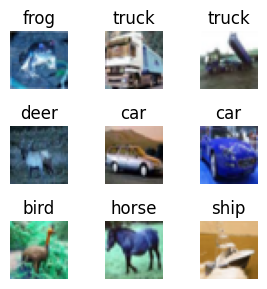

In [53]:
CATEGORIES = [
  'plane',
  'car',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck',
]

cv_gridshow(train_images, labels=train_labels, lmap=lambda label: CATEGORIES[label[0]])

### Defining convenience function

In [54]:
def compile_model(inputs, outputs):
  model = keras.Model(inputs, outputs)
  model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
  )
  return model

### Normalizing the data

In [55]:
train_images = train_images.astype(float) / 255
test_images = test_images.astype(float) / 255

### Building input layer

In [56]:
inputs = keras.Input(shape=(32, 32, 3))

### Non-convolutional model

In [73]:
layer = keras.layers.Flatten()
outputs = layer(inputs)

layer = keras.layers.Dense(1541, activation='relu', use_bias = False)
outputs = layer(outputs)

layer = keras.layers.Dense(1541, activation='relu', use_bias = False)
outputs = layer(outputs)

layer = keras.layers.Dense(10)
outputs = layer(outputs)

model = compile_model(inputs, outputs)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 dense_13 (Dense)            (None, 1541)              4733952   
                                                                 
 dense_14 (Dense)            (None, 1541)              2374681   
                                                                 
 dense_15 (Dense)            (None, 10)                15420     
                                                                 
Total params: 7,124,053
Trainable params: 7,124,053
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 3s 10ms/step


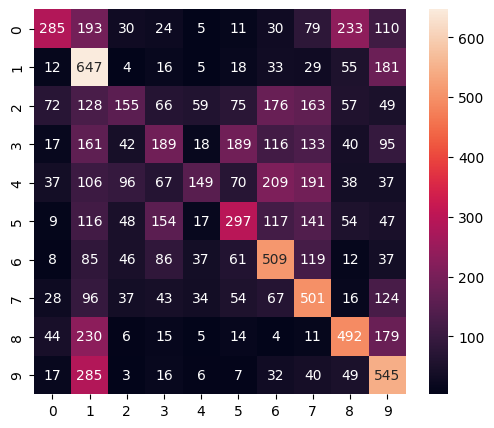

In [74]:
model.fit(train_images, train_labels)

model.evaluate(test_images, test_labels)

plot_confusion(model, test_images, test_labels)

### Convolutional model

In [85]:
layer = keras.layers.Conv2D(32, 3, activation='relu')
outputs = layer(inputs)

layer = keras.layers.Conv2D(32, 3, activation='relu')
outputs = layer(outputs)

layer = keras.layers.Conv2D(32, 3)
outputs = layer(outputs)

# layer = keras.layers.Conv2D(32, 3, activation='relu')
# outputs = layer(outputs)

# layer = keras.layers.Conv2D(32, 3, activation='relu')
# outputs = layer(outputs)

# layer = keras.layers.Conv2D(32, 3, activation='relu')
# outputs = layer(outputs)

layer = keras.layers.Flatten()
outputs = layer(outputs)

layer = keras.layers.Dense(10)
outputs = layer(outputs)

model = compile_model(inputs, outputs)

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_25 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 flatten_13 (Flatten)        (None, 21632)             0         
                                                                 
 dense_20 (Dense)            (None, 10)                216330    
                                                                 
Total params: 235,722
Trainable params: 235,722
Non-traina

313/313 [==============================] - 6s 20ms/step


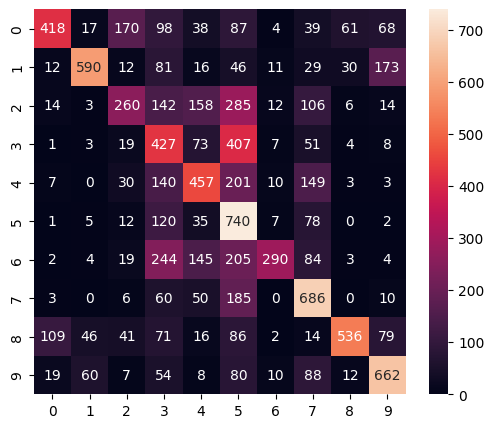

In [86]:
model.fit(train_images, train_labels)

model.evaluate(test_images, test_labels)

plot_confusion(model, test_images, test_labels)

You can click on the toc.png tab to the left to browse by section.